In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import plotly
import plotly.graph_objs as go
import plotly.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import TfidfVectorizer as TFIDF

# Load Dataset

In [6]:
Winedata = pd.read_csv('winemag-data-130k-v2.csv', index_col=0)

# Visualization 1-2

In [3]:
# Visualization 1
# Explore correlation between price and points

# Only keep rows with both price and points information
Winedata1 = Winedata.loc[Winedata['points'] > 0]
Winedata1 = Winedata1.loc[Winedata1['price'] > 0]


points = Winedata1['points']
price = Winedata1['price']

trace1 = go.Scatter(
    x = points,
    y = price,
    mode = 'markers'
)

layout = go.Layout(
    title='Scatter plot for points vs. price of wines',
    width=700,
    height=500,
    autosize=False,
    hovermode='closest',
    xaxis = dict(title = 'points'),
    yaxis = dict(title = 'price'))
data = [trace1]
fig1 = go.Figure(data=data, layout=layout)
py.iplot(fig1, filename='Scatter plot---Wine')

The draw time for this plot will be slow for all clients.


For visualization 1, I want to explore correlation between features price and points. I choose scatter plot since it is widely used and straightforward for showing correlation between two quantitative features. And because of the overlay part in above plot, my visualization also enables viewers to check corresponding (x,y) coordinates when mouse hovering on a point, which is convenient to low-level task such as Query->Identify (slide "tasks" pg.21). 

I use the default color (blue) in Plotly to fill the data points, which can make "pop-out" effect (slide "perception" pg.92) and immediately capture viewers' attention. The background is colored in white and all other parts are colored in black to avoid distracting viewers (slide "color" pg.53). 

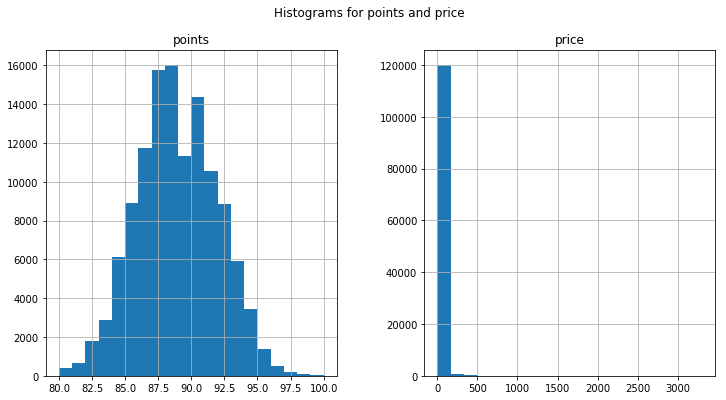

In [4]:
# Visualization 2
# View distributions of points and price

fig, axes = plt.subplots(1, 2, figsize=[12, 6])
fig.suptitle('Histograms for points and price')
Plots = Winedata1.hist(bins=20, ax=axes)

For visualization 2, I want to view distributions of two numeric features: points and price. And I apply the default "hist" command of Pandas library to draw the above two histograms. I choose the histogram as visual encoding since it is simple but effective for visualizing the distribution of continuous variable. As we learnt in class, the mark is Lines and the channels are Position, Area (slide "Marks & Channels" pg.13). Also the visualization is faceted in order to present the two features at same time, and viewers can easily examine both distributions without visual interference.

Again, I only use the default color (blue) to fill the bars, which can make "pop-out" effect (slide "perception" pg.92) and immediately capture viewers' attention. The background is colored in white and all other parts are colored in black to avoid causing visual clutter or distracting viewers (slide "color" pg.53). 

# Split the dataset randomly into train/test (80/20)

In [7]:
# Create a function to split the dataset randomly into train(80)/test(20)
# General idea is: 1.randomly shuffle the rows of dataset 2.Then select the first 80% cases as train set, the 
# remaining 20% cases as test set

def splitData(df):
    indexList = np.arange(df.shape[0]) # Get a list for index of rows
    np.random.shuffle(indexList) # Shuffle the index for random selection
    datalength = len(indexList)
    traindata_Length = math.floor((datalength*8)/10)
    trainData = df.iloc[indexList[:traindata_Length]] # Extract train data from dataframe
    testData = df.iloc[indexList[traindata_Length:]] # Extract test data from the dataframe
    return trainData, testData

# Preprocess the data

In [8]:
# Firstly, implement some basic data cleaning steps. Drop the columns with less contribution to our task 
# and drop NA, duplicate values in the remaining columns.

# The columns "taster name" and "taster_twitter_handle" are dropped because they are highly correlated 
# but hardly have correlation to the column "points". Columns "region_1" and "region_2" are dropped since
# they contain lots of NA values. And the columns "winery", "designation", "title" are dropped since 
# they contain a bunch of unique categories, which may lead to overfitting problem.

Winedata = pd.DataFrame(Winedata.drop(["title", "region_1", "region_2", "taster_name", 
                                        "taster_twitter_handle", "winery", "designation"], axis = 1))
Winedata_update = pd.DataFrame(Winedata.dropna().drop_duplicates().reset_index(drop = True))

# Show the first few rows of cleaned data
Winedata_update.head(8)

,country,description,points,price,province,variety
0,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Douro,Portuguese Red
1,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Pinot Gris
2,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Michigan,Riesling
3,US,"Much like the regular bottling from 2012, this...",87,65.0,Oregon,Pinot Noir
4,Spain,Blackberry and raspberry aromas show a typical...,87,15.0,Northern Spain,Tempranillo-Merlot
5,Italy,"Here's a bright, informal red that opens with ...",87,16.0,Sicily & Sardinia,Frappato
6,France,This dry and restrained wine offers spice in p...,87,24.0,Alsace,Gewürztraminer
7,Germany,Savory dried thyme notes accent sunnier flavor...,87,12.0,Rheinhessen,Gewürztraminer


In [9]:
# One-hot encoding for categorical features
# Select a sample set with size 20K since running the whole dataset 
# on my computer consumes a lot of time with no result    

WineSample = Winedata_update.sample(n = 20000).reset_index(drop = True)
WineSample_update = pd.get_dummies(WineSample, columns = ["variety", "province", "country"])

In [11]:
# Preprocessing for description text, bascially removing stop words.

import nltk
nltk.download('punkt')
stopWords = stopwords.words("english")
for i in range(len(WineSample_update)):
    Text = WineSample_update.loc[i, "description"]
    stemWord = []
    for ele in word_tokenize(Text):
        if(ele.isalpha() and ele not in stopWords):
            stemWord.append(PorterStemmer().stem(ele.lower()))
    WineSample_update.loc[i, "description"] = " ".join(stemWord)

[nltk_data] Downloading package punkt to /Users/zhang/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


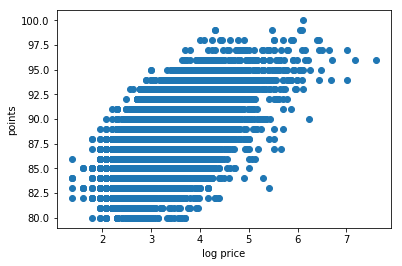

In [17]:
x = np.log(WineSample_update["price"])
y = WineSample_update["points"]
plt.scatter(x,y)
plt.xlabel("log price")
plt.ylabel("points")

# Based on the below plot, we find there is an overall positive linear relationship between log(price) and points.
# So it is appropriate to transform price into log(price) for our regression task.
WineSample_update.loc[:, "price"] = np.log(WineSample_update["price"])

In [19]:
# Standardization for continuous features
from sklearn.preprocessing import StandardScaler

# Randomly split data into train and test set, using the function created in previous part.
trainData, testData = splitData(WineSample_update)
trainData = trainData.reset_index(drop = True)
testData = testData.reset_index(drop = True)

# Standardization step for train and test set
from sklearn.preprocessing import StandardScaler
datascaler = StandardScaler().fit(trainData.loc[:, ["price", "points"]]) # use only information of train data
trainData.loc[:, ["price", "points"]]= datascaler.transform(trainData.loc[:, ["price", "points"]])
testData.loc[:, ["price", "points"]] = datascaler.transform(testData.loc[:, ["price", "points"]])

# Create a function to seperate the points column
def seperatePoint(df):
    return df.drop('points',axis=1), df['points']

trainData_input, trainData_points = seperatePoint(trainData)
testData_input, testData_points = seperatePoint(testData)

In [20]:
# Apply Tf-idf and LDA for description text

Tfidf_model = TFIDF(sublinear_tf = True).fit(trainData_input["description"]) # use only information of train data
trainData_desc = Tfidf_model.transform(trainData_input["description"])
testData_desc = Tfidf_model.transform(testData_input["description"])
LDA_model = LDA(n_components = 10).fit(trainData_desc) # use only information of train data
trainData_desc = LDA_model.transform(trainData_desc)
testData_desc = LDA_model.transform(testData_desc)

# Then put the results of tf_idf into train data input and test data input
for j in range(np.shape(trainData_desc)[1]):
    trainData_input[str(j+1)] = trainData_desc[:, j]
for k in range(np.shape(testData_desc)[1]):
    testData_input[str(k+1)] = testData_desc[:, k]

# Now we can drop the original description column then get corresponding values for train input and test input
train_input_val = trainData_input.drop("description", axis = 1).values
test_input_val = testData_input.drop("description", axis = 1).values

/Users/zhang/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning:

The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.



# Build Machine Learning models & Visualization 3

## 1. Ridge Regression

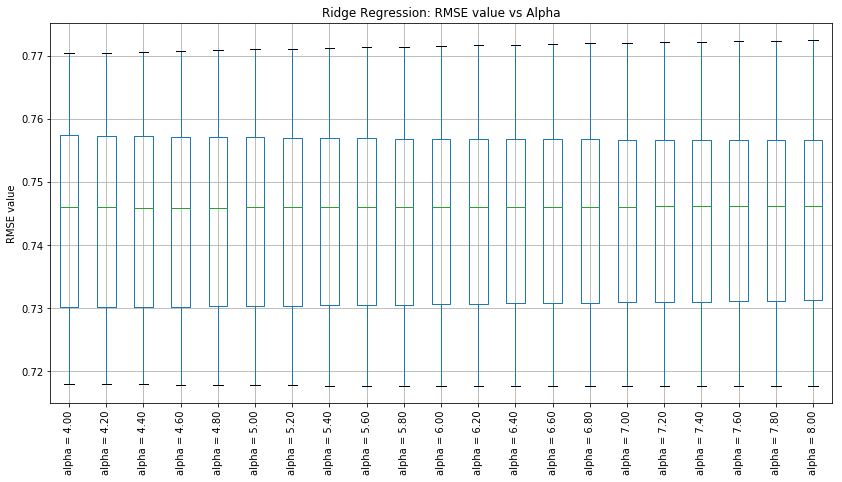

In [22]:
# Choose ridge regression since it doesn't penalize all the feature’s estimate arbitrarily. And it can 
# avoid overfitting problem when the features are highly correlated with each other

RidgeScore = []
for i in range(40, 82, 2):
    RidgeModel = Ridge(alpha = i/10)
    perform_score = cross_val_score(RidgeModel, train_input_val, trainData_points, cv=10, scoring="neg_mean_squared_error")
    RidgeScore.append(np.sqrt(np.abs(perform_score)))

# Plot the scores (RMSE as metric) for different hyperparameters in parallel boxplot
Ridge_perform_score = pd.DataFrame()
for score, alpha in zip(RidgeScore, range(40, 82, 2)):
    Ridge_perform_score["alpha = %.2f" % (alpha / 10)]=score
fig = Ridge_perform_score.boxplot(figsize = (14, 7), rot = 90)
fig.set_ylabel("RMSE value")
fig.set_title("Ridge Regression: RMSE value vs Alpha")
plt.show()

## 2. Lasso Regression

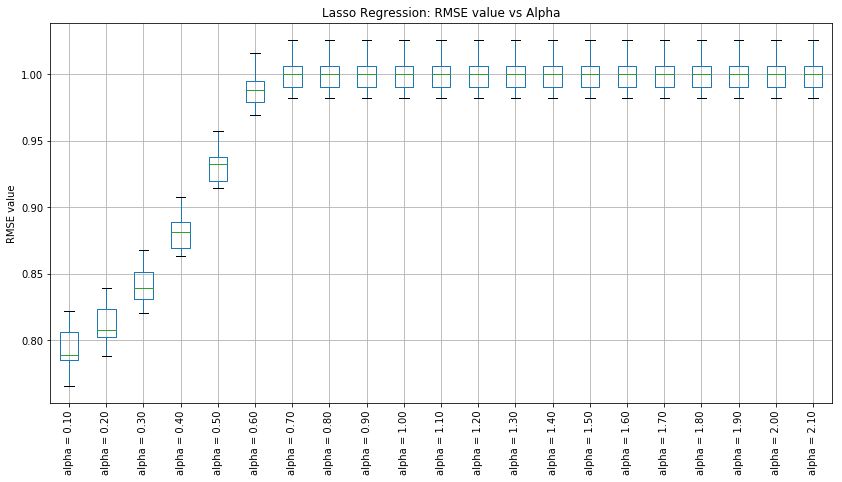

In [23]:
# Choose lasso regression since it can provide a very good prediction accuracy. Shrinking and removing the
# coefficients can reduce variance without a substantial increase of the bias. And it also can 
# increase the model interpretability by eliminating irrelevant variables that are not associated with 
# the response variable, so that to avoid overfitting problem
# Source: https://beta.vu.nl/nl/Images/werkstuk-fonti_tcm235-836234.pdf

LassoScore = []
for j in range(1,22):
    LassoModel = Lasso(alpha = j/10)
    perform_score = cross_val_score(LassoModel, train_input_val, trainData_points, cv=10, scoring="neg_mean_squared_error")
    LassoScore.append(np.sqrt(np.abs(perform_score)))
    
# Plot the scores (RMSE as metric) for different hyperparameters in parallel boxplot    
Lasso_perform_score = pd.DataFrame()
for score, alpha in zip(LassoScore, range(1, 22)):
    Lasso_perform_score["alpha = %.2f" % (alpha / 10)] = score
fig = Lasso_perform_score.boxplot(figsize = (14, 7), rot = 90)
fig.set_ylabel("RMSE value")
fig.set_title("Lasso Regression: RMSE value vs Alpha")
plt.show()

## 3. Random Forest

In [24]:
# Choose Random Forest since it is one of the most accurate learning algorithms available, 
# and runs efficiently on large dataset. It also can handle lots of input variables without variable deletion
# Source: http://amateurdatascientist.blogspot.com/2012/01/random-forest-algorithm.html

RFScore = []
for k in range(10, 100, 10):
    RFModel = RandomForestRegressor(n_estimators = k)
    perform_score = cross_val_score(RFModel, train_input_val, trainData_points, cv=10, scoring="neg_mean_squared_error")
    RFScore.append(np.sqrt(np.abs(perform_score)))
    

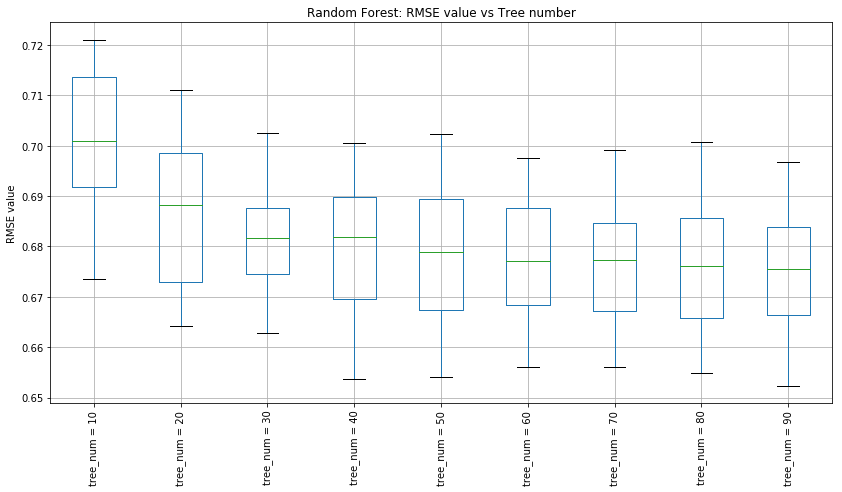

In [25]:
# Plot the scores (RMSE as metric) for different hyperparameters in parallel boxplot 
RF_perform_score = pd.DataFrame()
for score, treenum in zip(RFScore, range(10, 100, 10)):
    RF_perform_score["tree_num = %d" % treenum] = score
fig = RF_perform_score.boxplot(figsize = (14, 7), rot = 90)
fig.set_ylabel("RMSE value")
fig.set_title("Random Forest: RMSE value vs Tree number")
plt.show()

In the above part, I create three parallel boxplots to find the optimal hyperparameters for each of my 3 chosen models using 10-fold cross-validation on the train set (same folds for each of the 3 models). I set the Root Mean Square Error (RMSE) as evaluation metric since it is appropriate and widely used for regression task. And I found the optimal hyperparameters by looking the three boxplots then picking each hyperparameter with the lowest RMSE value. So for Ridge Regression, the optimal hyperparameter is alpha = 4.00; for Lasso Regression, the optimal hyperparameter is alpha = 0.10; for Random Forest, the optimal hyperparameter is n_estimators = 90.

And my Visualization 3 is made by the above three parallel boxplots, generated through the default "boxplot" command in Pandas library. I choose parallel boxplot since it can show not only general performance for each hyperparameter value, but also specific distribution of performance scores with respect to each hyperparameter value. And the parallel boxplot contributes to high-level task (Consume->Discover, slide "tasks" pg.21) as well. For example, we can easily discover that there is a general increase trend for RMSE value as alpha value becomes larger in Lasso Regression.

For the color choice, I only use the default color (blue) to draw the boxes, which can make "pop-out" effect (slide "perception" pg.92) and immediately capture viewers' attention. The background is colored in white and axes are colored in black to avoid causing visual clutter or distracting viewers (slide "color" pg.53).

# Run on test set & Visualization 4

In [26]:
# Using the optimal hyperparameters from the previous part to build the 3 optimal models, 
# then predict the corresponding points for test set and report performance

Ridge_opt = Ridge(alpha = 4)
Lasso_opt = Lasso(alpha = 0.1)
RF_opt = RandomForestRegressor(n_estimators = 90)

# Run on test set
Ridge_opt.fit(train_input_val, trainData_points)
Ridge_opt_points = Ridge_opt.predict(test_input_val)

Lasso_opt.fit(train_input_val, trainData_points)
Lasso_opt_points = Lasso_opt.predict(test_input_val)

RF_opt.fit(train_input_val, trainData_points)
RF_opt_points = RF_opt.predict(test_input_val)

# Report performance
# Here I still RMSE as evaluation metric for this task
Ridge_opt_rmse = np.sqrt(mean_squared_error(Ridge_opt_points, testData_points))
Lasso_opt_rmse = np.sqrt(mean_squared_error(Lasso_opt_points, testData_points))
RF_opt_rmse = np.sqrt(mean_squared_error(RF_opt_points, testData_points))
print("The RMSE for optimal Ridge Regression model is", Ridge_opt_rmse)
print("The RMSE for optimal Lasso Regression model is", Lasso_opt_rmse)
print("The RMSE for optimal Random Forest model is", RF_opt_rmse)

The RMSE for optimal Ridge Regression model is 0.7363206170580119
The RMSE for optimal Lasso Regression model is 0.7960898460811594
The RMSE for optimal Random Forest model is 0.6796090307338998


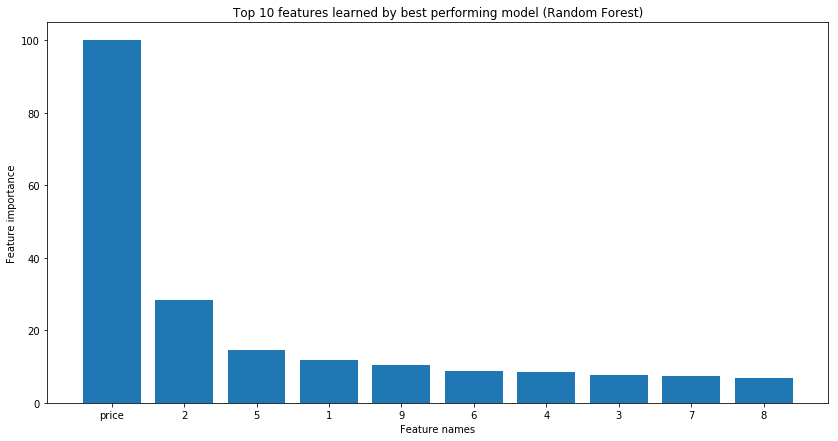

In [31]:
# Create a visualization showing the top features learned by the best performing model
# Based on above part, we know that the Random Forest has the lowest RMSE value, which is the best performing model

# Apply the default "feature_importances_" method in RF model to select the top features
feat_importance = RF_opt.feature_importances_
feat_importance = 100 * (feat_importance / feat_importance.max()) # Re-define the feature importance like percentage form
featSort = np.flip(np.argsort(feat_importance)[-10:], axis = 0) # Select top 10 features
barPos = np.arange(10)
feat_selected = np.array(testData_input.drop("description", axis = 1).columns)[featSort]

plt.figure(figsize=(14,7))
plt.bar(barPos, feat_importance[featSort])
plt.xticks(barPos, feat_selected)
plt.xlabel("Feature names")
plt.ylabel("Feature importance")
plt.title("Top 10 features learned by best performing model (Random Forest)")
plt.show()

The Visualization 4 shows the top 10 features learned by best performing model (Random Forest). The numbers on the x-axis are actually feature names derived from tf-idf output. I choose bar chart since it can show clear comparison for importance value among these features. And I present the feature importance in descending order, which is convenient for viewers to examine. 

For color choice, I still use the default color (blue) to fill the bars, which can make "pop-out" effect (slide "perception" pg.92) and immediately capture viewers' attention. The background is colored in white and all other parts are colored in black to avoid causing visual clutter or distracting viewers (slide "color" pg.53).